In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ajout du chemin vers les scripts sources
sys.path.append('..')

from src.clustering_utils import compare_clustering_methods
from src.viz_utils import plot_clustering_comparison, plot_projections
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Configuration esthétique
%matplotlib inline
sns.set_theme(style="whitegrid")

### 1. Chargement des données

In [3]:
# Chargement de la matrice d'embeddings (1506, 2048)
features = np.load("../data/processed/features_resnet.npy")

# Chargement du metadata.csv
df = pd.read_csv("../data/metadata.csv")

print(f"✅ Features chargées : {features.shape}")
print(f"✅ Métadonnées chargées : {len(df)} lignes")

✅ Features chargées : (1506, 2048)
✅ Métadonnées chargées : 1506 lignes


### 2. Standardisation des features

In [4]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print(f"Moyenne après scaling : {features_scaled.mean():.2f}")
print(f"Écart-type après scaling : {features_scaled.std():.2f}")

Moyenne après scaling : -0.00
Écart-type après scaling : 1.00


### 3. Réduction de Dimension (PCA & t-SNE)

Dimensions réduites par PCA : 257
Dimensions pour visualisation : (1506, 2)


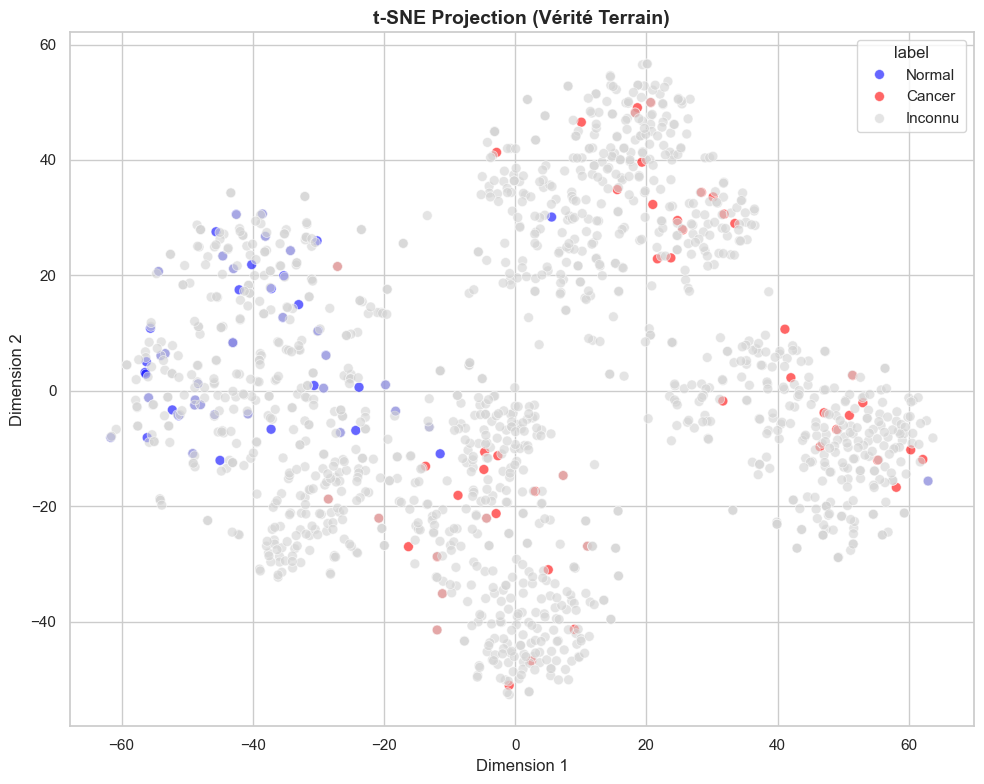

In [5]:
# 1. PCA pour le clustering (on garde 95% de la variance)
pca = PCA(n_components=0.95, random_state=42)
features_pca = pca.fit_transform(features_scaled)

# 2. t-SNE pour la visualisation 2D
tsne = TSNE(
    n_components=2, perplexity=30, random_state=42, init="pca", learning_rate="auto"
)
projections = tsne.fit_transform(features_pca)

print(f"Dimensions réduites par PCA : {features_pca.shape[1]}")
print(f"Dimensions pour visualisation : {projections.shape}")

# 3. Visualisation de la projection t-SNE

true_labels = df["label"].replace({-1: "Inconnu", 0: "Normal", 1: "Cancer"})
palette = {"Inconnu": "lightgrey", "Normal": "blue", "Cancer": "red"}

plot_projections(projections, true_labels, title="t-SNE Projection (Vérité Terrain)", palette=palette)

### 4. Compétition des algorithmes

## Diagnostic DBSCAN : Trouver l'epsilon optimal

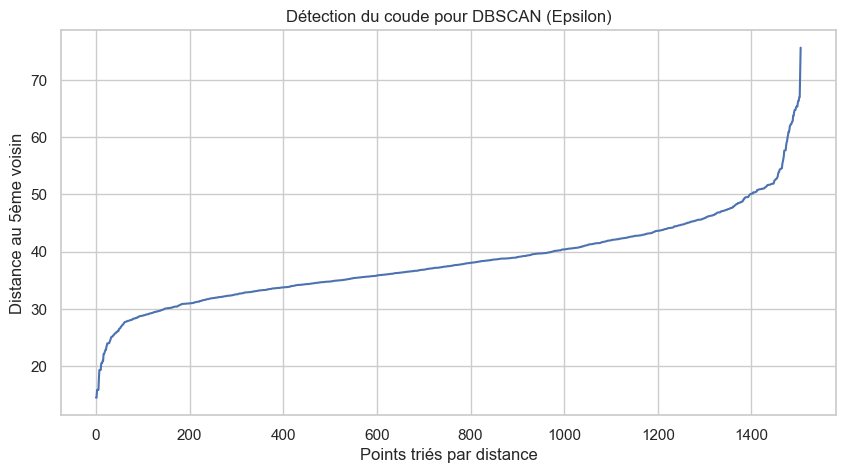

Distance min: 14.54
Distance max: 75.60
Distance moyenne: 38.34
Distance médiane: 37.48
Percentile 90: 47.57


In [6]:
from sklearn.neighbors import NearestNeighbors

# On cherche la distance au 5ème voisin (car min_samples = 5)
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(features_pca)
distances, indices = nbrs.kneighbors(features_pca)

# On trie les distances
distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title("Détection du coude pour DBSCAN (Epsilon)")
plt.xlabel("Points triés par distance")
plt.ylabel("Distance au 5ème voisin")
plt.grid(True)
plt.show()

print(f"Distance min: {distances.min():.2f}")
print(f"Distance max: {distances.max():.2f}")
print(f"Distance moyenne: {distances.mean():.2f}")
print(f"Distance médiane: {np.median(distances):.2f}")
print(f"Percentile 90: {np.percentile(distances, 90):.2f}")

In [7]:
# Appel de la fonction de comparaison créée dans src/clustering_utils.py
labels_dict, scores_dict = compare_clustering_methods(features_pca, df)

# Affichage des scores ARI
print("--- Scores ARI (Comparaison avec les 100 labels réels) ---")
for model, score in scores_dict.items():
    print(f"Targeting Accuracy ({model}) : {score:.4f}")

--- Scores ARI (Comparaison avec les 100 labels réels) ---
Targeting Accuracy (K-Means) : 0.4302
Targeting Accuracy (GMM) : 0.4302
Targeting Accuracy (Agglomératif) : 0.5137


### 5. Visualisation Comparative

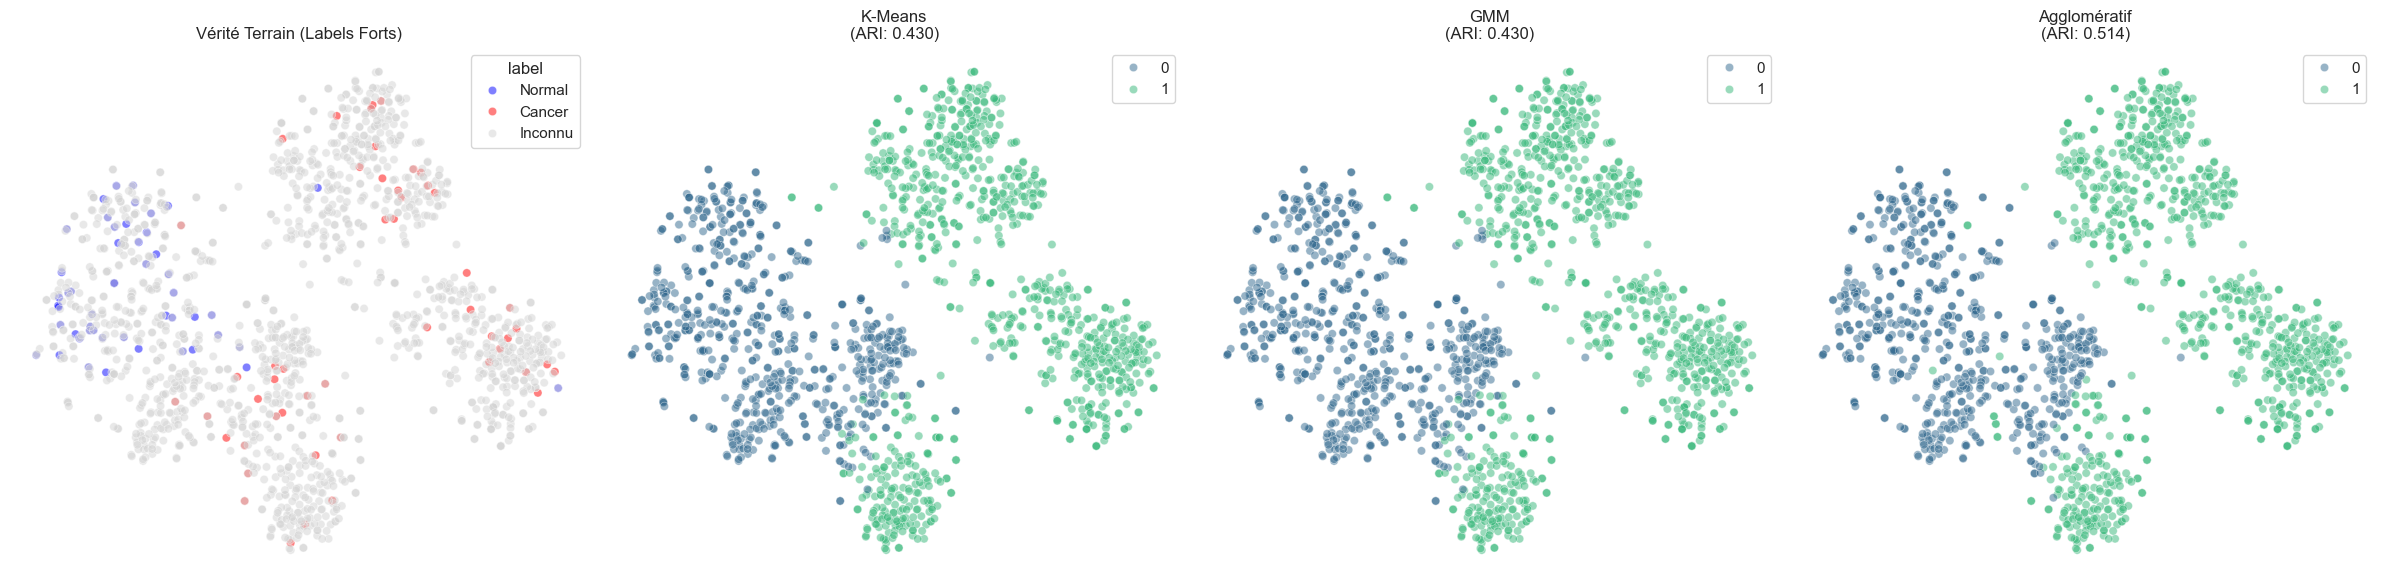

In [8]:
# Appel de la fonction de visualisation créée dans src/viz_utils.py
plot_clustering_comparison(projections, df, labels_dict, scores_dict)

### 5b. DBSCAN (séparé)

DBSCAN est géré séparément car son fonctionnement diffère fondamentalement des autres algorithmes.

🔹 Nombre de clusters trouvés : 2
🔸 Nombre de points de bruit : 1006 / 1506
📊 DBSCAN ARI Score: -0.0033


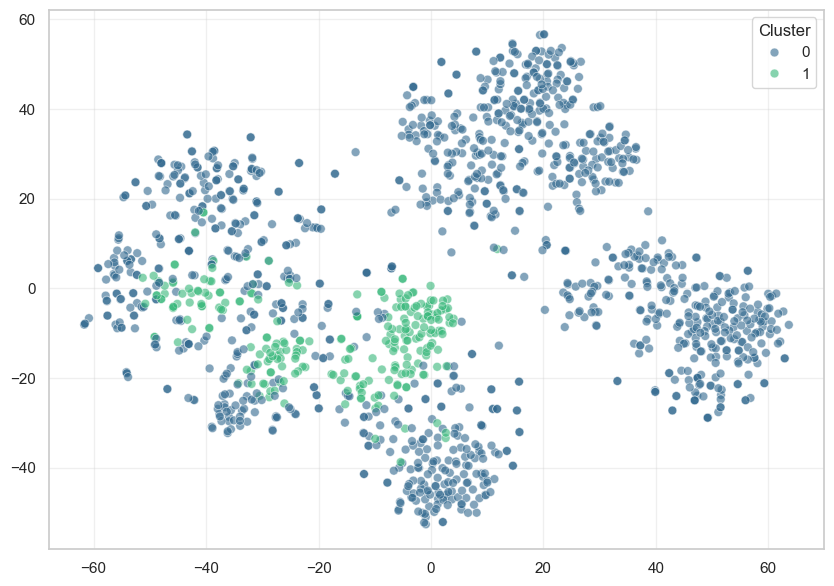

In [24]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
import numpy as np

# 1. DBSCAN simple avec paramètres par défaut
dbscan = DBSCAN(eps=38, min_samples=50)
db_clusters = dbscan.fit_predict(features_pca)

# 2. Analyse des résultats
n_clusters = len(set(db_clusters)) - (1 if -1 in db_clusters else 0)
n_noise = np.sum(db_clusters == -1)

print(f"🔹 Nombre de clusters trouvés : {n_clusters}")
print(f"🔸 Nombre de points de bruit : {n_noise} / {len(db_clusters)}")

# 3. Calcul de l'ARI
mask = df["label"] != -1
true_labels = df[mask]["label"].values

noise_mask = db_clusters == -1
if noise_mask.any() and n_clusters > 0:
    most_common = np.bincount(db_clusters[~noise_mask]).argmax()
    db_clusters[noise_mask] = most_common

db_clusters_strong = db_clusters[mask]
ari_score = adjusted_rand_score(true_labels, db_clusters_strong)
scores_dict["DBSCAN"] = ari_score
labels_dict["DBSCAN"] = db_clusters

print(f"📊 DBSCAN ARI Score: {ari_score:.4f}")

# 4. Visualisation
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=projections[:, 0], 
    y=projections[:, 1], 
    hue=db_clusters,
    palette="viridis",
    alpha=0.6,
    edgecolor="w",
    s=40
)
# plt.title(f"DBSCAN (eps=35, min_samples=5) - ARI: {ari_score:.4f}")
plt.legend(title="Cluster")
plt.grid(True, alpha=0.3)
plt.show()

### 5b.0 Optimisation DBSCAN : Test d'hyperparamètres

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
import numpy as np

# Test de plusieurs hyperparamètres
eps_values = [30, 40, 50, 60, 80]
min_samples_values = [3, 5, 10]

mask = df["label"] != -1
true_labels = df[mask]["label"].values

results = []

print("=" * 70)
print("🔍 DBSCAN : Test d'hyperparamètres")
print("=" * 70)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(features_pca)
        
        # Gestion du bruit
        noise_mask = clusters == -1
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = noise_mask.sum()
        
        if noise_mask.any() and n_clusters > 0:
            most_common = np.bincount(clusters[~noise_mask]).argmax()
            clusters[noise_mask] = most_common
        
        # Calcul ARI
        clusters_strong = clusters[mask]
        ari = adjusted_rand_score(true_labels, clusters_strong)
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'ari': ari
        })
        
        print(f"eps={eps:2d}, min_samples={min_samples} → clusters={n_clusters}, noise={n_noise:4d}, ARI={ari:.4f}")

# Meilleur résultat
best = max(results, key=lambda x: x['ari'])
print("\n" + "=" * 70)
print(f"✅ Meilleur : eps={best['eps']}, min_samples={best['min_samples']} → ARI={best['ari']:.4f}")
print("=" * 70)

🔍 DBSCAN : Test d'hyperparamètres
eps=30, min_samples=3 → clusters=82, noise=1002, ARI=0.0614
eps=30, min_samples=5 → clusters=18, noise=1248, ARI=0.0380
eps=30, min_samples=10 → clusters=4, noise=1396, ARI=0.0121
eps=40, min_samples=3 → clusters=19, noise= 274, ARI=-0.0003
eps=40, min_samples=5 → clusters=1, noise= 356, ARI=0.0000
eps=40, min_samples=10 → clusters=1, noise= 436, ARI=0.0000
eps=50, min_samples=3 → clusters=2, noise=  54, ARI=0.0000
eps=50, min_samples=5 → clusters=1, noise=  58, ARI=0.0000
eps=50, min_samples=10 → clusters=1, noise=  69, ARI=0.0000
eps=60, min_samples=3 → clusters=1, noise=  16, ARI=0.0000
eps=60, min_samples=5 → clusters=1, noise=  17, ARI=0.0000
eps=60, min_samples=10 → clusters=1, noise=  17, ARI=0.0000
eps=80, min_samples=3 → clusters=1, noise=   0, ARI=0.0000
eps=80, min_samples=5 → clusters=1, noise=   0, ARI=0.0000
eps=80, min_samples=10 → clusters=1, noise=   0, ARI=0.0000

✅ Meilleur : eps=30, min_samples=3 → ARI=0.0614


In [18]:
# Affichage récapitulatif des scores ARI (tous les algos y compris DBSCAN)
print("\n" + "="*60)
print("📊 RÉSUMÉ : Scores ARI de tous les algorithmes")
print("="*60)
for model, score in sorted(scores_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{model:20} : {score:.4f}")
print("="*60)


📊 RÉSUMÉ : Scores ARI de tous les algorithmes
Agglomératif         : 0.5137
K-Means              : 0.4302
GMM                  : 0.4302
DBSCAN               : 0.0380


In [ ]:
# Sélection du meilleur (à ajuster selon tes résultats)
best_model = "Agglomératif"

# On ajoute les labels faibles au DataFrame
df["weak_label"] = labels_dict[best_model]

# On crée une colonne combinée : label réel si présent, sinon label faible
df["final_label"] = df["label"].where(df["label"] != -1, df["weak_label"])

# Sauvegarde du nouveau fichier de travail
output_path = "../data/metadata_with_weak_labels.csv"
df.to_csv(output_path, index=False)

print(f"💾 Fichier sauvegardé avec succès : {output_path}")